In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 10:43:29 2016

@author: Rob Romijnders
"""
direc = '/PhysioNet/CNN_AE_RNN'


import numpy as np

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
import matplotlib.pyplot as plt
import os
from tensorflow.contrib.tensorboard.plugins import projector
from AE_ts_model import Model, open_data, plot_data, plot_z_run

In [4]:
"""Hyperparameters"""
LOG_DIR = "/PhysioNet/CNN_AE_RNN"
config = {}                             #Put all configuration information into the dict
config['num_layers'] = 2                #number of layers of stacked RNN's
config['hidden_size'] = 90              #memory cells in a layer
config['max_grad_norm'] = 5             #maximum gradient norm during training
config['batch_size'] = batch_size = 64  
config['learning_rate'] = .005
config['crd'] = 1                       #Hyperparameter for future generalization
config['num_l'] = 20                    #number of units in the latent space

plot_every = 100                        #after _plot_every_ GD steps, there's console output
max_iterations = 500                   #maximum number of iterations
dropout = 0.5                           #Dropout rate 

We have 3999 observations with 140 dimensions


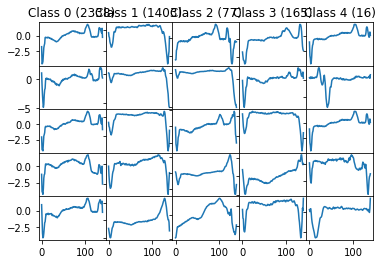

Train with approximately 8 epochs


In [5]:
"""Load the data"""
X_train, X_val, y_train, y_val = open_data(direc)

N = X_train.shape[0]
Nval = X_val.shape[0]
D = X_train.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
    y_val -= base

# Plot data   # and save high quality plt.savefig('data_examples.eps', format='eps', dpi=1000)
plot_data(X_train,y_train)


# Proclaim the epochs
epochs = np.floor(batch_size * max_iterations / N)
print('Train with approximately %d epochs' % (epochs))


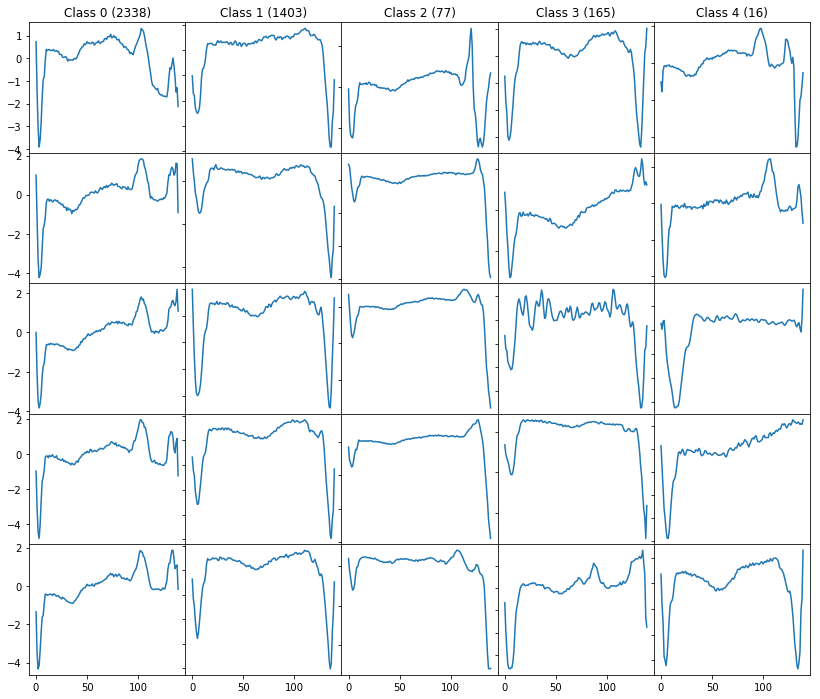

In [32]:
plot_data(X_train,y_train)

In [6]:
"""Training time!"""
model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))

if True:
    sess.run(model.init_op)
    train_writer = tf.summary.FileWriter(LOG_DIR + '/train', sess.graph)  # writer for Tensorboard
    test_writer = tf.summary.FileWriter(LOG_DIR + '/test')  # writer for Tensorboard

    step = 0  # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):
        batch_ind = np.random.choice(N, batch_size, replace=False)
        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step, model.merged],
                          feed_dict={model.x: X_train[batch_ind], model.keep_prob: dropout})

        if i % plot_every == 0:
            # Save train performances
            perf_collect[0, step] = loss_train = result[0]
            loss_train_seq, lost_train_lat = result[1], result[2]

            train_writer.add_summary(result[4], i)

            # Calculate and save validation performance
            batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

            result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                              feed_dict={model.x: X_val[batch_ind_val], model.keep_prob: 1.0})
            perf_collect[1, step] = loss_val = result[0]
            loss_val_seq, lost_val_lat = result[1], result[2]
            # and save to Tensorboard
            summary_str = result[3]
            test_writer.add_summary(summary_str, i)
            test_writer.flush()

            print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
            i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
            step += 1
#if False:
    ##Extract the latent space coordinates of the validation set
    start = 0
    label = []  # The label to save to visualize the latent space
    z_run = []

    while start + batch_size < Nval:
        run_ind = range(start, start + batch_size)
        z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: X_val[run_ind], model.keep_prob: 1.0})
        z_run.append(z_mu_fetch)
        start += batch_size

    z_run = np.concatenate(z_run, axis=0)
    label = y_val[:start]

    plot_z_run(z_run, label)

At      0 /    500 train (3.263, 1.446, 1.817), val (2.307, 1.058,1.249) in order (total, seq, lat)
At    100 /    500 train (0.012, 0.000, 0.012), val (0.050, 0.000,0.050) in order (total, seq, lat)
At    200 /    500 train (0.007, 0.000, 0.007), val (0.073, 0.000,0.073) in order (total, seq, lat)
At    300 /    500 train (0.005, 0.000, 0.005), val (0.099, 0.000,0.099) in order (total, seq, lat)
At    400 /    500 train (0.004, 0.000, 0.004), val (0.127, 0.000,0.127) in order (total, seq, lat)
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.001311
[t-SNE] Iteration 25: error = 1.0880181, gradient norm = 0.0068341
[t-SNE] Iteration 50: error = 1.0087690, gradient norm = 0.0095652
[t-SNE] Iteration 75: error = 0.6847469, gradient norm = 0.0013615
[t-SNE] Iteration 100: error = 0.6459024, gradient norm = 0.0018144
[t-SNE] KL divergence after 100 iterations with early ex

In [28]:
plt.rcParams['figure.figsize'] = 14,12

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 0.001311
[t-SNE] Iteration 25: error = 1.0802152, gradient norm = 0.0062596
[t-SNE] Iteration 50: error = 0.9763735, gradient norm = 0.0084691
[t-SNE] Iteration 75: error = 0.6576953, gradient norm = 0.0015419
[t-SNE] Iteration 100: error = 0.6119788, gradient norm = 0.0010127
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.611979
[t-SNE] Iteration 125: error = 0.5665026, gradient norm = 0.0007269
[t-SNE] Iteration 125: gradient norm 0.000727. Finished.
[t-SNE] Error after 125 iterations: 0.611979


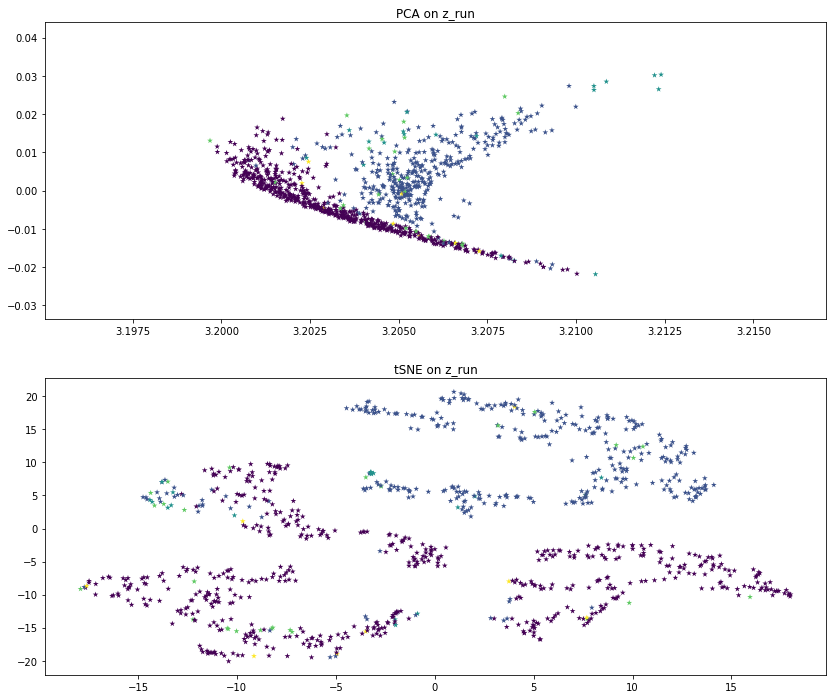

In [29]:
plot_z_run(z_run, label)
plt.show()

In [9]:
# Save the projections also to Tensorboard
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model_2.ckpt"), step)
config = projector.ProjectorConfig()

In [10]:
# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = model.z_mu.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_2.tsv')

In [11]:
# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(train_writer, config)
saver.save(sess, os.path.join(LOG_DIR, "model_2.ckpt"), step + 1)
train_writer.flush()

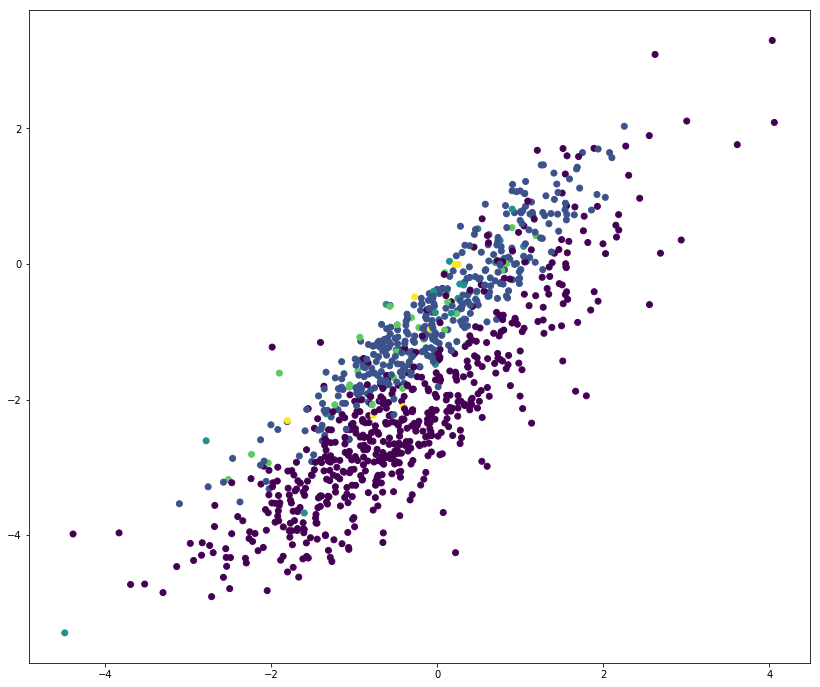

In [30]:
plt.scatter(X_val[:,0], X_val[:,1], c=y_val , marker='o')
plt.show()

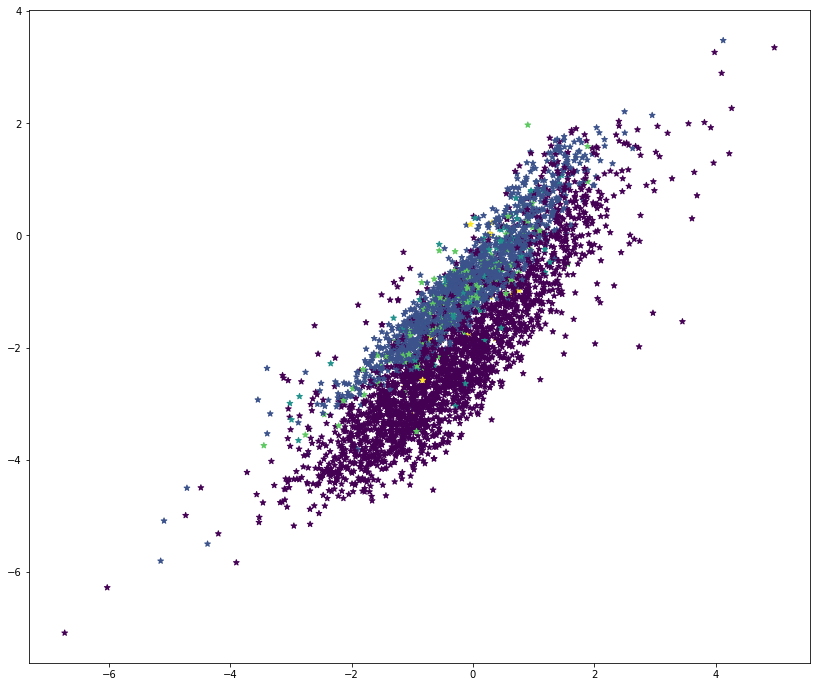

In [31]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train , marker='*')
plt.show()

In [24]:
tf.__version__

'1.1.0'